In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from accelerate import init_empty_weights

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

import os, torch
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="0"

[Model source](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224)

In [2]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" 

[Dataset source](https://huggingface.co/datasets/sartajbhuvaji/Brain-Tumor-Classification)

In [3]:
dataset = load_dataset("sartajbhuvaji/Brain-Tumor-Classification")

0


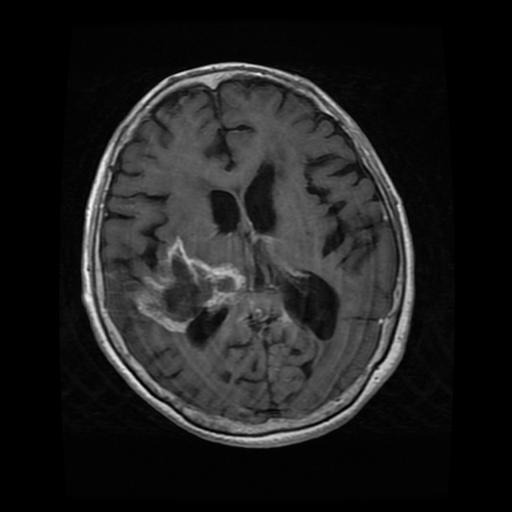

In [4]:
example = dataset["Training"][100]
print(example['label'])
example['image']

# Training

### Pre processing

In [5]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [7]:
# split up training into training + validation
splits = dataset["Training"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [8]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

### Actual training

In [9]:
labels = dataset["Training"].features["label"].names
label2id, id2label = dict(), dict()
label2id, id2label =  {"glioma":0, "meningioma":1, "no":2, "pituitary":3}, {0:"glioma", 1:"meningioma", 2:"no", 3:"pituitary"}
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [10]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 32

args = TrainingArguments(
    f"{model_name}-brain-tumour-classification",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [12]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """
    eval_pred are the logits of the model, compared to the label ids ground truths.
    Computes on a batch of predictions, used for the Trainer class.
    """
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

/tmp/ipykernel_1131038/680278550.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
# using transformers auto Trainer class
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [14]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model("./swin_tiny_tuned")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: arnaud-gucciardi (arn). Use `wandb login --relogin` to force relogin


/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.197771,0.522648
1,1.275200,0.811911,0.703833
2,0.741200,0.533095,0.749129
4,0.477900,0.293701,0.888502
5,0.375700,0.264836,0.912892
6,0.375700,0.230209,0.930314
8,0.263200,0.140837,0.940767
9,0.263200,0.166387,0.940767
10,0.236600,0.141797,0.944251
12,0.214200,0.152112,0.940767


/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

***** train metrics *****
  epoch                    =      17.7778
  total_flos               = 1063220949GF
  train_loss               =       0.3849
  train_runtime            =   0:04:09.16
  train_samples_per_second =      207.331
  train_steps_per_second   =        0.482


In [15]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/home/arnaud/miniconda3/envs/a6001/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =    17.7778
  eval_accuracy           =     0.9582
  eval_loss               =     0.1176
  eval_runtime            = 0:00:01.14
  eval_samples_per_second =    249.667
  eval_steps_per_second   =       2.61


# Inference

In [16]:
image_processor = AutoImageProcessor.from_pretrained("./swin_tiny_tuned")
model = AutoModelForImageClassification.from_pretrained("./swin_tiny_tuned")

test image 0 

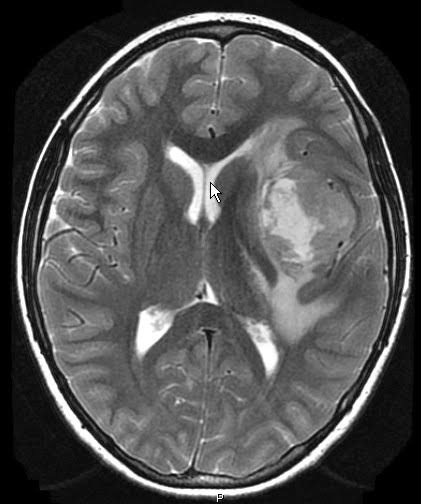

In [17]:
image = dataset['Testing'][10]['image']
image

In [18]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax().item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
print("True class label:", dataset['Testing'][0]['label'])
dic_class = {0:"glioma", 1:"meningioma", 2:"no", 3:"pituitary"}
print("True class name:", dic_class[dataset['Testing'][10]['label']])

Predicted class: no_tumor
True class label: 0
True class name: glioma
